In [10]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd

def load_result_csv_files(directory):
    result_dfs = []
    file_paths = []
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith("results.csv"):
                file_path = os.path.join(root, filename)
                relative_path = os.path.relpath(file_path, directory)
                df = pd.read_csv(file_path)
                result_dfs.append(df)
                file_paths.append(relative_path)
    return result_dfs, file_paths

exp = "" # greedy sparse_learning movement importance weight_magnitude
directory_path = "/workdir/optimal-summaries-public/_models_train_prune/" + exp
result_dfs, file_paths = load_result_csv_files(directory_path)
len(result_dfs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


75

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
combined_df = pd.concat(result_dfs, ignore_index=True).round(3)
combined_df = combined_df[combined_df["Split"] == "test"].drop(columns=["Split"])
combined_df["Dataset"] = combined_df["Dataset"].replace({"mimic": "MIMIC", "spoken_arabic_digits": "SpokenArabicDigits", "tiselac": "Tiselac"})
combined_df["Model"] = combined_df["Model"].replace({"atomics_sum2atomics_False": "2Layers H2C", "atomics_sum2atomics_True": "2Layers H2A", "original": "Original", "shared_encode_time_dim_False": "Shared Time", "shared_encode_time_dim_True": "Shared Feature"})
combined_df["Pruning"] = combined_df["Pruning"].replace({"Greedy": "Greedy Wrapper", "importance": "Importance", "movement": "Movement", "sparse_learning": "Sparse Learning", "weight_magnitude": "Weight Magnitude"})
combined_df.columns = [col.replace("Total parameter", "Total") for col in combined_df.columns]
combined_df.columns = [col.replace("Remaining parameter", "Remaining") for col in combined_df.columns]
combined_df.columns = [col.replace("Jaccard Similarity", "Jaccard") for col in combined_df.columns]
combined_df.loc[combined_df["Pruning"] == "Before", "Jaccard"] = float("NaN")

combined_df.columns

Index(['Model', 'Dataset', 'Seed', 'Pruning', 'Finetuned', 'AUC', 'ACC', 'F1',
       'Total', 'Remaining', 'Jaccard'],
      dtype='object')

## Before Pruning

In [13]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

dataset = "SpokenArabicDigits" # MIMIC, SpokenArabicDigits, Tiselac

agg = {"AUC":["mean", "std"], "ACC":["mean", "std"], "F1":["mean", "std"], "Total":["mean"]}
per_set = combined_df[ (combined_df["Pruning"] == "Before")].drop(columns=['Seed', "Remaining", "Jaccard", "Pruning", "Finetuned"]).groupby(["Dataset", "Model"]).agg(agg).round(3)
#(combined_df["Dataset"] == dataset) &

float_format = "{:.2%}"

per_set[("AUC")] = per_set[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("AUC", "std")].map(float_format.format)
per_set[("ACC")] = per_set[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("ACC", "std")].map(float_format.format)
per_set[("F1")] = per_set[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("F1", "std")].map(float_format.format)
per_set.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
per_set.columns = per_set.columns.droplevel(1)

per_set[("Total")] = per_set[("Total")].astype(int)

with open("tex/" + exp + 'Before Pruning.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

per_set


AUC             ACC  \
Dataset            Model                                            
MIMIC              2Layers H2A      91.20 ± 0.40%   83.40 ± 0.60%   
                   2Layers H2C      87.10 ± 0.60%   85.70 ± 0.60%   
                   Original         86.90 ± 0.90%   86.10 ± 0.50%   
                   Shared Feature   91.10 ± 0.20%   83.70 ± 0.30%   
                   Shared Time      91.80 ± 0.30%   84.50 ± 0.50%   
SpokenArabicDigits 2Layers H2A      97.50 ± 1.10%   79.90 ± 5.40%   
                   2Layers H2C      52.30 ± 4.00%   11.70 ± 2.80%   
                   Original         50.20 ± 0.30%   10.20 ± 0.30%   
                   Shared Feature   51.40 ± 0.50%   11.40 ± 0.50%   
                   Shared Time      99.90 ± 0.00%   96.80 ± 0.20%   
Tiselac            2Layers H2A      95.90 ± 0.20%   72.30 ± 0.60%   
                   2Layers H2C      95.80 ± 0.20%   72.30 ± 0.60%   
                   Original        81.10 ± 22.90%  53.70 ± 31.50%   
                   Shared Feature   96.40 ± 0.30%   74.50 ± 1.10%   
                   Shared Time      97.10 ± 0.00%   78.30 ± 0.20%   

                                               F1  Total  
Dataset            Model                                  
MIMIC              2Layers H2A      84.40 ± 0.60%    568  
                   2Layers H2C      85.90 ± 0.50%   1816  
                   Original         86.30 ± 0.40%   2628  
                   Shared Feature   84.50 ± 0.20%    132  
                   Shared Time      85.20 ± 0.40%    112  
SpokenArabicDigits 2Layers H2A      79.70 ± 5.70%   1008  
                   2Layers H2C       3.20 ± 2.10%   1584  
                   Original          2.30 ± 0.60%  10300  
                   Shared Feature    4.20 ± 0.60%    796  
                   Shared Time      96.80 ± 0.20%     56  
Tiselac            2Layers H2A      67.70 ± 0.50%    400  
                   2Layers H2C      67.70 ± 0.40%    832  
                   Original        48.20 ± 33.20%   2324  
                   Shared Feature   69.40 ± 1.10%    236  
                   Shared Time      72.90 ± 0.30%     44

## Per Dataset

In [14]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

dataset = "Tiselac" # MIMIC, SpokenArabicDigits, Tiselac

agg = {"AUC":["mean", "std"], "ACC":["mean", "std"], "F1":["mean", "std"], "Total":["mean"], "Remaining":["mean"], "Jaccard":["mean"]}
per_set = combined_df[combined_df["Dataset"] == dataset].drop(columns=["Dataset", 'Seed']).groupby(["Model", "Pruning", "Finetuned"]).agg(agg).round(3)
per_set[("Remaining / Total")] = per_set[("Remaining", "mean")].astype(int).astype(str) +" / "+ per_set[("Total", "mean")].astype(int).astype(str)
per_set.drop(columns=[("Total", "mean"), ("Remaining", "mean")], inplace=True)

float_format = "{:.2%}"

per_set[("Jaccard", "mean")] = per_set[("Jaccard", "mean")].map(float_format.format).replace("nan%", "nan")

per_set[("AUC")] = per_set[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("AUC", "std")].map(float_format.format)
per_set[("ACC")] = per_set[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("ACC", "std")].map(float_format.format)
per_set[("F1")] = per_set[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("F1", "std")].map(float_format.format)
per_set.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
per_set.columns = per_set.columns.droplevel(1)
# per_set.reset_index(inplace=True)

with open("tex/" + exp + "Pruning " + dataset + '.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

per_set


AUC             ACC  \
Model          Pruning          Finetuned                                   
2Layers H2A    Before           False       95.90 ± 0.20%   72.30 ± 0.60%   
               Greedy Wrapper   False       91.50 ± 2.20%  51.50 ± 10.60%   
                                True        94.00 ± 0.50%   65.80 ± 2.10%   
               Importance       True        92.60 ± 0.40%   63.60 ± 1.10%   
               Movement         True        93.60 ± 0.60%   64.90 ± 0.80%   
               Sparse Learning  True        95.50 ± 0.30%   71.40 ± 0.00%   
               Weight Magnitude True        93.30 ± 0.80%   64.70 ± 2.30%   
2Layers H2C    Before           False       95.80 ± 0.20%   72.30 ± 0.60%   
               Greedy Wrapper   False       89.60 ± 0.90%   46.40 ± 3.40%   
                                True        92.40 ± 0.10%   63.10 ± 0.70%   
               Importance       True        92.10 ± 1.20%   61.90 ± 3.10%   
               Movement         True        92.90 ± 0.50%   64.00 ± 0.50%   
               Sparse Learning  True        93.60 ± 0.60%   65.40 ± 1.10%   
               Weight Magnitude True        92.20 ± 0.50%   61.90 ± 0.70%   
Original       Before           False      81.10 ± 22.90%  53.70 ± 31.50%   
               Greedy Wrapper   False      77.10 ± 22.50%  23.50 ± 13.90%   
                                True        90.40 ± 2.90%   57.70 ± 7.80%   
               Importance       True        91.00 ± 0.30%   59.50 ± 0.80%   
               Movement         True        91.80 ± 1.60%   61.60 ± 3.10%   
               Sparse Learning  True        93.90 ± 0.30%   66.20 ± 1.10%   
               Weight Magnitude True        90.40 ± 0.50%   57.60 ± 1.60%   
Shared Feature Before           False       96.40 ± 0.30%   74.50 ± 1.10%   
               Greedy Wrapper   False       95.00 ± 0.90%   68.10 ± 4.50%   
                                True        96.40 ± 0.30%   74.50 ± 1.10%   
               Importance       True        95.60 ± 0.30%   72.10 ± 1.10%   
               Movement         True        95.80 ± 0.20%   72.80 ± 0.60%   
               Sparse Learning  True        96.80 ± 0.10%   76.80 ± 0.20%   
               Weight Magnitude True        95.70 ± 0.20%   72.50 ± 0.70%   
Shared Time    Before           False       97.10 ± 0.00%   78.30 ± 0.20%   
               Greedy Wrapper   False       97.10 ± 0.10%   78.20 ± 0.30%   
                                True        97.20 ± 0.10%   78.50 ± 0.10%   
               Importance       True        97.20 ± 0.10%   78.30 ± 0.50%   
               Movement         True        97.20 ± 0.10%   78.30 ± 0.50%   
               Sparse Learning  True        97.00 ± 0.20%   77.80 ± 0.50%   
               Weight Magnitude True        97.20 ± 0.10%   78.30 ± 0.50%   

                                                       F1  Jaccard  \
Model          Pruning          Finetuned                            
2Layers H2A    Before           False       67.70 ± 0.50%      nan   
               Greedy Wrapper   False       46.90 ± 9.60%   31.00%   
                                True        61.40 ± 2.40%   31.00%   
               Importance       True        60.00 ± 0.40%   17.60%   
               Movement         True        61.70 ± 0.80%   13.70%   
               Sparse Learning  True        67.00 ± 0.50%   60.70%   
               Weight Magnitude True        61.40 ± 1.50%   13.00%   
2Layers H2C    Before           False       67.70 ± 0.40%      nan   
               Greedy Wrapper   False       40.20 ± 1.00%   30.40%   
                                True        59.60 ± 1.00%   30.40%   
               Importance       True        58.80 ± 2.60%   30.00%   
               Movement         True        60.30 ± 0.80%   20.00%   
               Sparse Learning  True        62.40 ± 1.00%    0.00%   
               Weight Magnitude True        58.50 ± 1.00%   12.20%   
Original       Before           False      48.20 ± 33.20%      nan   
              

## Stability

In [15]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

dataset = "Tiselac" # MIMIC, SpokenArabicDigits, Tiselac 

agg = {"Total":["mean"], "Remaining":["mean"], "Jaccard":["mean"]}

per_set = combined_df[(combined_df["Dataset"] == dataset) & (combined_df["Pruning"] != "Before") & (combined_df["Finetuned"] == True)] \
    .drop(columns=["Dataset", 'Seed', "AUC", "ACC", "F1", "Finetuned"]) \
    .groupby(["Pruning", "Model"]).agg(agg).round(3)
    
per_set[("Remaining / Total")] = per_set[("Remaining", "mean")].astype(int).astype(str) +" / "+ per_set[("Total", "mean")].astype(int).astype(str)
per_set.drop(columns=[("Total", "mean"), ("Remaining", "mean")], inplace=True)

float_format = "{:.2%}"
per_set[("Jaccard", "mean")] = per_set[("Jaccard", "mean")].map(float_format.format).replace("nan%", "nan")

per_set.columns = per_set.columns.droplevel(1)
# per_set.reset_index(inplace=True)

# Insert line breaks after each pruning method
for idx, col in enumerate(per_set.columns):
    if idx % 5 == 0 and idx != 0:
        per_set.insert(idx, "", "")

with open("tex/" + exp + "Stability on " + dataset + '.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

per_set.T


Pruning           Greedy Wrapper                                        \
Model                2Layers H2A 2Layers H2C   Original Shared Feature   
Jaccard                   31.00%      30.40%      3.80%         55.20%   
Remaining / Total       88 / 400    88 / 832  44 / 2324       44 / 236   

Pruning                        Importance                         \
Model             Shared Time 2Layers H2A 2Layers H2C   Original   
Jaccard               100.00%      17.60%      30.00%      0.00%   
Remaining / Total     44 / 44    88 / 400    87 / 832  44 / 2324   

Pruning                                         Movement              \
Model             Shared Feature Shared Time 2Layers H2A 2Layers H2C   
Jaccard                   20.80%     100.00%      13.70%      20.00%   
Remaining / Total       44 / 236     44 / 44    88 / 400    88 / 832   

Pruning                                                 Sparse Learning  \
Model               Original Shared Feature Shared Time     2Layers H2A   
Jaccard                2.00%         16.70%     100.00%          60.70%   
Remaining / Total  44 / 2324       44 / 236     44 / 44        91 / 400   

Pruning                                                              \
Model             2Layers H2C   Original Shared Feature Shared Time   
Jaccard                 0.00%      7.50%         50.00%     100.00%   
Remaining / Total    52 / 832  36 / 2324       39 / 236     42 / 44   

Pruning           Weight Magnitude                                        \
Model                  2Layers H2A 2Layers H2C   Original Shared Feature   
Jaccard                     13.00%      12.20%      0.00%         12.70%   
Remaining / Total         88 / 400    88 / 832  44 / 2324       44 / 236   

Pruning                        
Model             Shared Time  
Jaccard               100.00%  
Remaining / Total     44 / 44

## Combined Plots

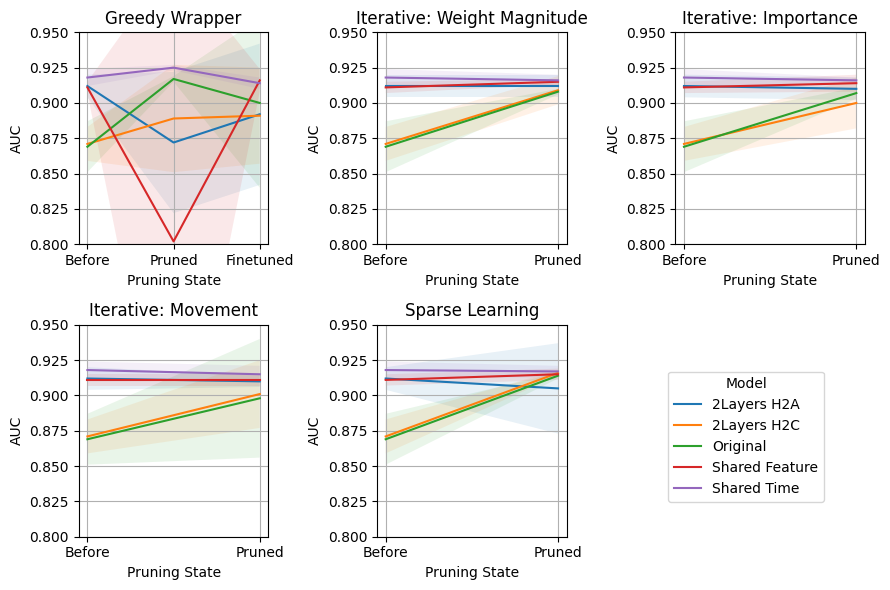

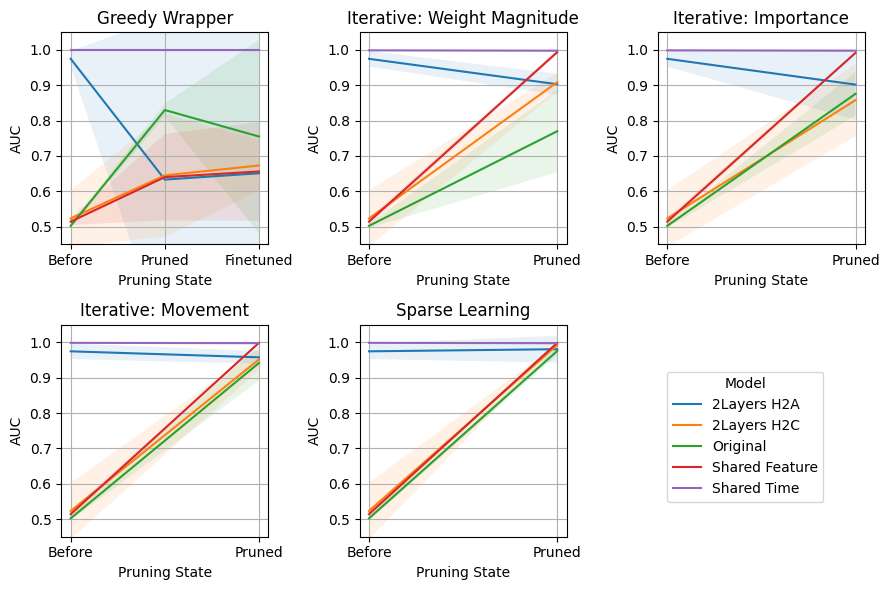

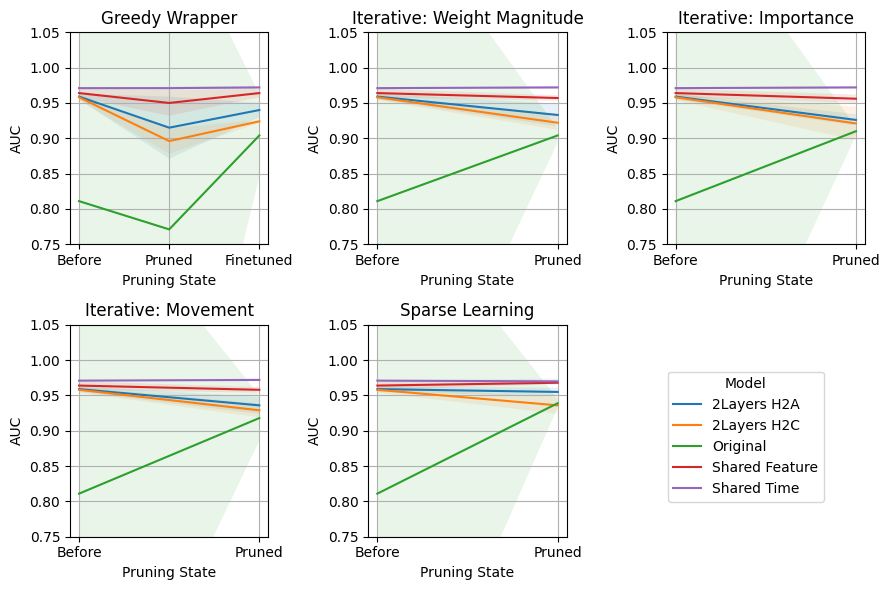

In [16]:
import matplotlib.pyplot as plt


for dataset in ["MIMIC", "SpokenArabicDigits", "Tiselac"]:
    
    # Determine the number of pruning methods
    num_prunings = 5  # Change this according to your dataset

    # Calculate the number of rows and columns for subplots
    num_rows = 2
    num_cols = 3

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    names = ["Greedy Wrapper", "Iterative: Weight Magnitude", "Iterative: Importance", "Iterative: Movement", "Sparse Learning", "Sparse Learning"]

    for i, pruning in enumerate(["Greedy Wrapper", "Weight Magnitude", "Importance", "Movement", "Sparse Learning", "Sparse Learning"]):
        agg = {"AUC": ["mean", "std"]}
        per_set = combined_df[(combined_df["Dataset"] == dataset) & (combined_df["Pruning"].isin((pruning, "Before")))] \
            .drop(columns=["Dataset", 'Seed', "Total", "Remaining", "Jaccard", "ACC", "F1"]) \
            .groupby(["Model", "Finetuned", "Pruning"]).agg(agg).round(3)

        df = per_set
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
        df = df.reset_index()

        pivot_df = df.pivot(index=["Pruning", 'Finetuned'], columns="Model", values=['AUC_mean', 'AUC_std'])

        row = i // 3
        col = i % 3

        ax = axes[row, col] if num_prunings > 1 else axes

        for column in pivot_df['AUC_mean'].columns:
            ax.plot(range(len(pivot_df.index)), pivot_df['AUC_mean'][column], label=column if pruning == "Greedy Wrapper" else "")
            ax.fill_between(range(len(pivot_df.index)),
                            pivot_df['AUC_mean'][column] - 2 * pivot_df['AUC_std'][column],
                            pivot_df['AUC_mean'][column] + 2 * pivot_df['AUC_std'][column],
                            alpha=0.1)

        ax.set_title(f'{names[i]}')
        ax.set_xlabel('Pruning State')
        ax.set_ylabel('AUC')
        if len(pivot_df.index) == 2:
            custom_labels = ['Before', 'Pruned']
        if len(pivot_df.index) == 3:
            custom_labels = ['Before', 'Pruned', 'Finetuned']
        ax.set_xticks(range(len(pivot_df.index)))
        ax.set_xticklabels(custom_labels, rotation=0, ha='center')

        if dataset == "MIMIC":
            ax.set_ylim(0.8, 0.95) # MIMIC
        elif dataset == "Tiselac":
            ax.set_ylim(0.75, 1.05) # Tiselac
        elif dataset == "SpokenArabicDigits":
            ax.set_ylim(0.45, 1.05) # SAD
        
        ax.grid(True)

    fig.legend(title="Model", loc=(0.75, 0.15))
    axes[-1, -1].remove()
    plt.tight_layout()
    plt.savefig("fig/Combined_Pruning_Plots_" + dataset + ".pdf", format='pdf')
    plt.show()


## ALL EXP (too big)

In [17]:
# Model,Indicators,Summaries,Dataset,Seed,Split,AUC,ACC,F1,Cutoff,Lower threshold,Upper threshold

agg = {"AUC":["mean", "std"], "ACC":["mean", "std"], "F1":["mean", "std"], "Total":["mean"], "Remaining":["mean"], "Jaccard":["mean"]}
per_set = combined_df.drop(columns=['Seed']).groupby(["Dataset", "Model", "Pruning", "Finetuned"]).agg(agg).round(3)
per_set[("Remaining / Total")] = per_set[("Remaining", "mean")].astype(int).astype(str) +" / "+ per_set[("Total", "mean")].astype(int).astype(str)
per_set.drop(columns=[("Total", "mean"), ("Remaining", "mean")], inplace=True)

float_format = "{:.2%}"

per_set[("Jaccard", "mean")] = per_set[("Jaccard", "mean")].map(float_format.format).replace("nan%", "nan")

per_set[("AUC")] = per_set[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("AUC", "std")].map(float_format.format)
per_set[("ACC")] = per_set[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("ACC", "std")].map(float_format.format)
per_set[("F1")] = per_set[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ per_set[("F1", "std")].map(float_format.format)
per_set.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
per_set.columns = per_set.columns.droplevel(1)
# per_set.reset_index(inplace=True)

with open("tex/" + exp + 'Pruning Full (too big).tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = per_set.to_latex(escape=True, index=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

# per_set


## Grouped

In [18]:
agg = {"AUC":["mean", "std"], "ACC":["mean", "std"], "F1":["mean", "std"], "Jaccard":["mean"]}
grouped = combined_df.drop(columns=["Seed", "Dataset", "Total", "Remaining"]).groupby(["Model", "Pruning", "Finetuned"]).agg(agg).round(3)#.reset_index()

float_format = "{:.2%}"

grouped[("Jaccard", "mean")] = grouped[("Jaccard", "mean")].map(float_format.format).replace("nan%", "nan")

grouped[("AUC")] = grouped[("AUC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ grouped[("AUC", "std")].map(float_format.format)
grouped[("ACC")] = grouped[("ACC", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ grouped[("ACC", "std")].map(float_format.format)
grouped[("F1")] = grouped[("F1", "mean")].map(float_format.format).map(lambda x: x.replace("%", "")) +" ± "+ grouped[("F1", "std")].map(float_format.format)
grouped.drop(columns=[("AUC", "mean"), ("ACC", "mean"), ("F1", "mean")], inplace=True)
grouped.columns = grouped.columns.droplevel(1)
# grouped.reset_index(inplace=True)

with open("tex/" + exp + 'Pruning Grouped.tex', 'w') as f:
    # tex = grouped.to_latex(convert_css=True)                            # styler
    tex = grouped.to_latex(escape=True) #, float_format="{:.2%}".format)   # df
    # tex = tex.replace('%', r'\%')
    f.write(tex)

grouped

AUC             ACC  \
Model          Pruning          Finetuned                                   
2Layers H2A    Before           False       94.90 ± 2.80%   78.50 ± 5.60%   
               Greedy Wrapper   False      80.70 ± 17.60%  50.50 ± 29.00%   
                                True       82.80 ± 18.80%  60.20 ± 29.70%   
               Importance       True        91.30 ± 2.70%  68.80 ± 13.20%   
               Movement         True        93.40 ± 2.20%   73.50 ± 8.60%   
               Sparse Learning  True        94.70 ± 3.60%   80.10 ± 7.80%   
               Weight Magnitude True        91.60 ± 1.60%  69.00 ± 12.30%   
2Layers H2C    Before           False      78.40 ± 19.20%  56.60 ± 32.70%   
               Greedy Wrapper   False      81.00 ± 13.20%  47.40 ± 30.90%   
                                True       82.90 ± 12.00%  55.00 ± 28.80%   
               Importance       True        89.30 ± 3.80%  64.70 ± 17.50%   
               Movement         True        92.70 ± 2.50%   72.90 ± 9.50%   
               Sparse Learning  True        94.80 ± 3.40%  79.70 ± 11.00%   
               Weight Magnitude True        91.30 ± 1.00%  67.80 ± 12.10%   
Original       Before           False      72.70 ± 20.80%  50.00 ± 36.10%   
               Greedy Wrapper   False      83.90 ± 12.90%  40.00 ± 36.00%   
                                True       85.30 ± 10.20%  51.20 ± 33.30%   
               Importance       True        89.80 ± 2.30%  65.00 ± 15.70%   
               Movement         True        91.90 ± 2.60%  70.90 ± 11.40%   
               Sparse Learning  True        94.30 ± 2.70%   76.70 ± 8.30%   
               Weight Magnitude True        86.10 ± 7.40%  57.70 ± 23.20%   
Shared Feature Before           False      79.60 ± 20.40%  56.50 ± 32.60%   
               Greedy Wrapper   False      79.70 ± 14.60%  51.00 ± 31.40%   
                                True       84.60 ± 14.80%  57.60 ± 33.10%   
               Importance       True        95.40 ± 3.40%   81.50 ± 7.40%   
               Movement         True        95.60 ± 3.80%   84.00 ± 9.80%   
               Sparse Learning  True        96.10 ± 3.70%   85.70 ± 8.50%   
               Weight Magnitude True        95.50 ± 3.40%   82.30 ± 7.80%   
Shared Time    Before           False       96.20 ± 3.40%   86.50 ± 7.80%   
               Greedy Wrapper   False       96.50 ± 3.20%   87.10 ± 8.10%   
                                True        96.20 ± 3.70%   86.60 ± 8.20%   
               Importance       True        96.20 ± 3.60%   86.10 ± 7.60%   
               Movement         True        96.10 ± 3.70%   86.20 ± 7.70%   
               Sparse Learning  True        96.20 ± 3.60%   86.10 ± 8.00%   
               Weight Magnitude True        96.20 ± 3.60%   86.20 ± 7.80%   

                                                       F1 Jaccard  
Model          Pruning          Finetuned                          
2Layers H2A    Before           False       77.20 ± 7.80%     nan  
               Greedy Wrapper   False      46.70 ± 32.60%  10.30%  
                                True       57.00 ± 33.00%  10.30%  
               Importance       True       67.50 ± 14.40%  11.00%  
               Movement         True       72.60 ± 10.20%  16.80%  
               Sparse Learning  True        78.70 ± 9.90%  36.90%  
               Weight Magnitude True       67.80 ± 13.40%  16.20%  
2Layers H2C    Before           False      52.30 ± 36.00%     nan  
               Greedy Wrapper   False      42.80 ± 35.00%  10.10%  
                                True       50.70 ± 33.80%  10.10%  
               Importance       True       63.50 ± 18.40%  44.10%  
               Movement         True       71.80 ± 11.20%  42.30%  
               Sparse Learning  True       79.00 ± 12.60%   4.40%  
               Weight Magnitude True       66.70 ± 13.60%  38.10%  
Original       Before           False      45.60 ± 39.50%     nan  
               Greedy Wrapper   False      33.70